# Домашнее задание № 9. Предобученные трансформеры 

### Задание 1 (8 баллов).
Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую. 
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).




In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 9.2 MB/s 
     |████████████████████████████████| 84 kB 1.1 MB/s 
     |████████████████████████████████| 596 kB 55.4 MB/s 
     |████████████████████████████████| 6.6 MB 41.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from transformers import TFAutoModel
from transformers import AutoTokenizer

In [ ]:
from google.colab import drive

ROOT_DIR = '/content/drive' 
drive.mount(ROOT_DIR)

Mounted at /content/drive


In [ ]:
data = pd.read_csv('drive/MyDrive/HSE_compling/HW_09/lenta_sample.csv')
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data.topic.value_counts()

Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: topic, dtype: int64

**Модель Geotrend/bert-base-ru-cased**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Geotrend/bert-base-ru-cased')
model_bert_ru = TFAutoModel.from_pretrained('Geotrend/bert-base-ru-cased')

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []
for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {label: i for i, label in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
model_bert_ru = TFAutoModel.from_pretrained('Geotrend/bert-base-ru-cased', trainable=False)

Some layers from the model checkpoint at Geotrend/bert-base-ru-cased were not used when initializing TFBertModel: ['mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Geotrend/bert-base-ru-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name='input_ids')

output = model_bert_ru({'input_ids': input_word_ids})

drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_bert_ru_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

model_bert_ru_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_bert_ru_clf.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=20,
            epochs=20)

Epoch 1/20
29/29 [==============================] - 42s 1s/step - loss: 2.9333 - accuracy: 0.0729 - rec_prec: 0.0000e+00 - val_loss: 2.7630 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 28s 976ms/step - loss: 2.8259 - accuracy: 0.0833 - rec_prec: 0.0000e+00 - val_loss: 2.6918 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 28s 966ms/step - loss: 2.8273 - accuracy: 0.0764 - rec_prec: 0.0000e+00 - val_loss: 2.7279 - val_accuracy: 0.0323 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 28s 960ms/step - loss: 2.7893 - accuracy: 0.0972 - rec_prec: 0.0000e+00 - val_loss: 2.6789 - val_accuracy: 0.1290 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 28s 967ms/step - loss: 2.7975 - accuracy: 0.1094 - rec_prec: 0.0000e+00 - val_loss: 2.6687 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 [====================

In [ ]:
def show_train_plot(model):
    print(model.history.history.keys())
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


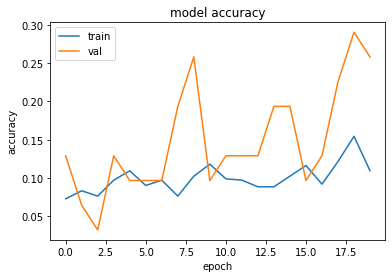

In [ ]:
show_train_plot(model_bert_ru_clf)

In [ ]:
pred = model_bert_ru_clf.predict(X_valid, batch_size=10).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       0.00      0.00      0.00         2
           Бизнес       0.50      0.50      0.50         2
           Россия       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
         Из жизни       0.14      1.00      0.24         3
         Культура       0.00      0.00      0.00         3
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
      Бывший СССР       0.00      0.00      0.00         3
              Дом       0.33      0.50      0.40         2
   Интернет и СМИ       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       

**Модель distilbert-base-multilingual-cased**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-multilingual-cased')
model_bert_ru = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased')

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/869M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
X = []
for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {label: i for i, label in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
model_distilbert_multi = TFAutoModel.from_pretrained('distilbert-base-multilingual-cased', trainable=False)

Some layers from the model checkpoint at distilbert-base-multilingual-cased were not used when initializing TFDistilBertModel: ['activation_13', 'vocab_layer_norm', 'vocab_transform', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name='input_ids')

output = model_distilbert_multi({'input_ids': input_word_ids})

drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_distilbert_multi_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

model_distilbert_multi_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_distilbert_multi_clf.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=20,
            epochs=20)

Epoch 1/20
29/29 [==============================] - 22s 501ms/step - loss: 2.8594 - accuracy: 0.0816 - rec_prec: 0.0000e+00 - val_loss: 2.7019 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 2/20
29/29 [==============================] - 13s 453ms/step - loss: 2.8086 - accuracy: 0.0729 - rec_prec: 0.0000e+00 - val_loss: 2.7348 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 3/20
29/29 [==============================] - 13s 459ms/step - loss: 2.7863 - accuracy: 0.0868 - rec_prec: 0.0000e+00 - val_loss: 2.7106 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 4/20
29/29 [==============================] - 13s 466ms/step - loss: 2.7634 - accuracy: 0.0833 - rec_prec: 0.0000e+00 - val_loss: 2.6961 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 13s 465ms/step - loss: 2.7536 - accuracy: 0.0938 - rec_prec: 0.0017 - val_loss: 2.7078 - val_accuracy: 0.0645 - val_rec_prec: 0.0000e+00
Epoch 6/20
29/29 [=====================

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


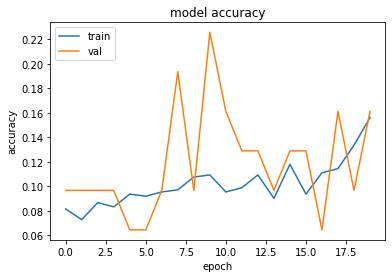

In [ ]:
show_train_plot(model_distilbert_multi_clf)

In [ ]:
pred = model_distilbert_multi_clf.predict(X_valid, batch_size=10).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       0.00      0.00      0.00         2
           Бизнес       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
         Из жизни       0.00      0.00      0.00         3
         Культура       0.40      0.67      0.50         3
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
      Бывший СССР       0.00      0.00      0.00         3
              Дом       0.12      0.50      0.20         2
   Интернет и СМИ       0.12      1.00      0.21         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       

**Модель Skoltech/russian-sensitive-topics**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('Skoltech/russian-sensitive-topics')
model_bert_ru = TFAutoModel.from_pretrained('Skoltech/russian-sensitive-topics')

Downloading:   0%|          | 0.00/524 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/18.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.34M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/680M [00:00<?, ?B/s]

Some layers from the model checkpoint at Skoltech/russian-sensitive-topics were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Skoltech/russian-sensitive-topics.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
X = []
for text in data.title:
    ids = tokenizer.encode(text)
    X.append(ids[:512])

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i: label for i, label in enumerate(set(data.topic.values))}
label2id = {label: i for i, label in id2label.items()}

y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

In [ ]:
model_sensitive = TFAutoModel.from_pretrained('Skoltech/russian-sensitive-topics', trainable=False)

Some layers from the model checkpoint at Skoltech/russian-sensitive-topics were not used when initializing TFBertModel: ['dropout_37', 'classifier']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at Skoltech/russian-sensitive-topics.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [ ]:
input_word_ids = tf.keras.layers.Input(shape=(512,), dtype=tf.int32,
                                     name='input_ids')

output = model_sensitive({'input_ids': input_word_ids})

drop = tf.keras.layers.Dropout(0.1)(output[0][:, 0]) 
dense = tf.keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_sensitive_clf = tf.keras.Model(inputs=input_word_ids, outputs=dense)

model_sensitive_clf.compile(tf.optimizers.Adam(learning_rate=2e-3), 
                    loss='categorical_crossentropy', 
                    metrics=['accuracy', tf.keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])

In [ ]:
model_sensitive_clf.fit(X_train, y_train, 
            validation_data=(X_valid, y_valid),
            batch_size=20,
            epochs=20)

Epoch 1/20
29/29 [==============================] - 43s 1s/step - loss: 3.0150 - accuracy: 0.0729 - rec_prec: 0.0000e+00 - val_loss: 2.7739 - val_accuracy: 0.0645 - val_rec_prec: 0.0323
Epoch 2/20
29/29 [==============================] - 28s 968ms/step - loss: 3.0146 - accuracy: 0.0556 - rec_prec: 0.0000e+00 - val_loss: 2.7181 - val_accuracy: 0.1613 - val_rec_prec: 0.0645
Epoch 3/20
29/29 [==============================] - 28s 970ms/step - loss: 2.8902 - accuracy: 0.0955 - rec_prec: 0.0000e+00 - val_loss: 2.6683 - val_accuracy: 0.1290 - val_rec_prec: 0.0323
Epoch 4/20
29/29 [==============================] - 28s 959ms/step - loss: 2.9068 - accuracy: 0.0781 - rec_prec: 0.0000e+00 - val_loss: 2.7256 - val_accuracy: 0.0968 - val_rec_prec: 0.0000e+00
Epoch 5/20
29/29 [==============================] - 28s 964ms/step - loss: 2.9104 - accuracy: 0.0694 - rec_prec: 0.0000e+00 - val_loss: 2.7922 - val_accuracy: 0.1290 - val_rec_prec: 0.0645
Epoch 6/20
29/29 [==============================] - 28

dict_keys(['loss', 'accuracy', 'rec_prec', 'val_loss', 'val_accuracy', 'val_rec_prec'])


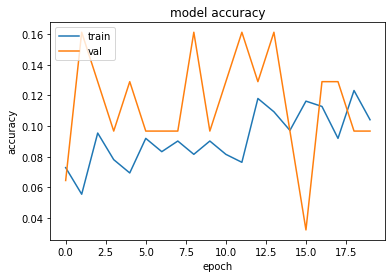

In [ ]:
show_train_plot(model_sensitive_clf)

In [ ]:
pred = model_sensitive_clf.predict(X_valid, batch_size=10).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

              Мир       0.00      0.00      0.00         1
            Спорт       0.12      0.50      0.20         2
           Бизнес       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
          Легпром       0.00      0.00      0.00         1
         Ценности       0.00      0.00      0.00         2
         Из жизни       0.09      0.67      0.16         3
         Культура       0.00      0.00      0.00         3
        Экономика       0.00      0.00      0.00         2
       Библиотека       0.00      0.00      0.00         0
      Бывший СССР       0.00      0.00      0.00         3
              Дом       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       

По метрикам побеждает первая модель (Geotrend/bert-base-ru-cased): ее средняя F1-мера 0.16, тогда как у моделей distilbert-base-multilingual-cased и Skoltech/russian-sensitive-topics F1-мера равна 0.07 и 0.03 соответственно. У первой модели также ненулевые метрики для четырех меток классов, у третьей - для трех, у третьей - для двух.

### Задание  2 (2 балла)

Ответьте на следующие вопросы (напишите хотя бы по несколько предложений):

1) Чем ROBERTA отличается от BERT? В какой статье описана ROBERTA?

2) Чем модель T5 отличается от ROBERTA/BERT? 

1) ROBERTA описана в статье 'RoBERTa: A Robustly Optimized BERT Pretraining Approach' (Yinhan Liu, Myle Ott, Naman Goyal, Jingfei Du, Mandar Joshi, Danqi Chen, Omer Levy, Mike Lewis, Luke Zettlemoyer, Veselin Stoyanov, 2019). Отличия ROBERTA от BERT следующие: 1) модель обучалась дольше, с бОльшим размером батча и на бОльшем количестве данных (CCNews, OpenWebText, Stories); 2) при ее обучении не ставилась задача предсказания следующего предложения (next sentence prediction); 3) при обучении использовался другой способ токенизации (BPE, в котором используются не Unicode символы, а байты); 4) при обучении использовалось динамическое маскирование.

2) Модель T5 отличается от BERT/ROBERTA главным образом тем, что она представляет собой иной формат входных-выходных данных. Тогда как BERT/ROBERTA на выход подают либо метку класса, либо фрагмент входных данных, в модели T5 и вход, и выход представлены текстовыми строками (text-to-text format). Таким образом, T5 можно использовать сразу для большого числа задач, включая классификацию, машинный перевод, вопросно-ответные системы.